In [1]:
from builtins import range,input

In [2]:
from keras.layers import Input,Lambda,Dense, Flatten

Using TensorFlow backend.


In [3]:
from keras.models import Model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2

In [5]:
def show(img,cmap=None,size=(10,15)):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=size)
    ax=fig.add_subplot(111)
    ax.set_title(img.shape)
    ax.imshow(img,cmap=cmap)

In [6]:
IMAGE_SIZE = [100,100] ## feel free to change based on input data

In [27]:
epochs = 1
batch_size = 1000

In [8]:
train_path = '../large_files/fruits-360-small/Training/'
valid_path = '../large_files/fruits-360-small/Validation/'

In [9]:
image_files = glob(train_path+'*/*.jp*g')
valid_image_files = glob(train_path+'*/*.jp*g')

In [10]:
## getting classes
folders = glob(train_path + '/*')

In [11]:
folders

['../large_files/fruits-360-small/Training\\Apple Golden 1',
 '../large_files/fruits-360-small/Training\\Avocado',
 '../large_files/fruits-360-small/Training\\Banana',
 '../large_files/fruits-360-small/Training\\Kiwi',
 '../large_files/fruits-360-small/Training\\Lemon',
 '../large_files/fruits-360-small/Training\\Mango',
 '../large_files/fruits-360-small/Training\\Raspberry',
 '../large_files/fruits-360-small/Training\\Strawberry']

In [12]:
#show(cv2.imread(np.random.choice(image_files)))

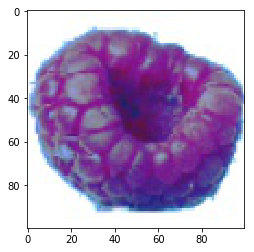

In [13]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [14]:
IMAGE_SIZE+[3]

[100, 100, 3]

In [15]:
## Keras Model Architecture

vgg = VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

prediction = Dense(len(folders),activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input,outputs=prediction)

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [16]:
model.compile(
loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['accuracy'])


In [17]:
gen = ImageDataGenerator(
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
vertical_flip=True,
preprocessing_function=preprocess_input)

In [18]:
test_gen = gen.flow_from_directory(valid_path,target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 1354 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


In [57]:
labels = [None] * len(test_gen.class_indices)

In [20]:
for k,v in test_gen.class_indices.items():
    labels[v] = k

In [21]:
labels[0]

'Apple Golden 1'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: <built-in method min of numpy.ndarray object at 0x0000021B10A686C0> max: 151.061


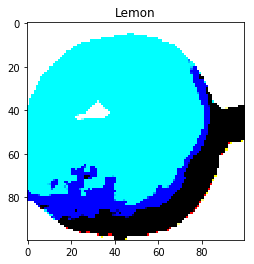

In [22]:
for x,y in test_gen:
    print("min:",x[0].min,"max:",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [28]:
# create generators
train_generator = gen.flow_from_directory(train_path,
                                         target_size=IMAGE_SIZE,
                                         shuffle=True,
                                         batch_size=batch_size)

valid_generator = gen.flow_from_directory(valid_path,
                                         target_size=IMAGE_SIZE,
                                         shuffle=False,
                                         batch_size=batch_size)

Found 3827 images belonging to 8 classes.
Found 1354 images belonging to 8 classes.


In [30]:
# Model Fit
r = model.fit_generator(train_generator,
                        validation_data=valid_generator,
                        epochs=epochs,
                        steps_per_epoch=len(image_files) // batch_size,
                        validation_steps=len(valid_image_files) // batch_size
                       )

Epoch 1/1
3/3 [==============================] - 420s 140s/step - loss: 9.5566 - acc: 0.3457 - val_loss: 5.9869 - val_acc: 0.5997


In [31]:
r.history

{'val_loss': [5.986860741540635],
 'val_acc': [0.5997045796854281],
 'loss': [9.556785042732058],
 'acc': [0.34665723468121346]}

In [62]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(valid_generator, valid_generator.samples // valid_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
#print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[201   0   0  21   7   0   0   0]
 [  1   0   4 121  17   0   0   0]
 [  0   0 157   0   9   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [ 22   0   0   1 141   0   0   0]
 [  3   0   1 138  24   0   0   0]
 [  0   0   2   1   0   0 163   0]
 [  0   0  83  26  25   0  30   0]]
Classification Report


In [60]:
from sklearn import preprocessing
all_labels = labels
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
        c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

0.7619390190656246

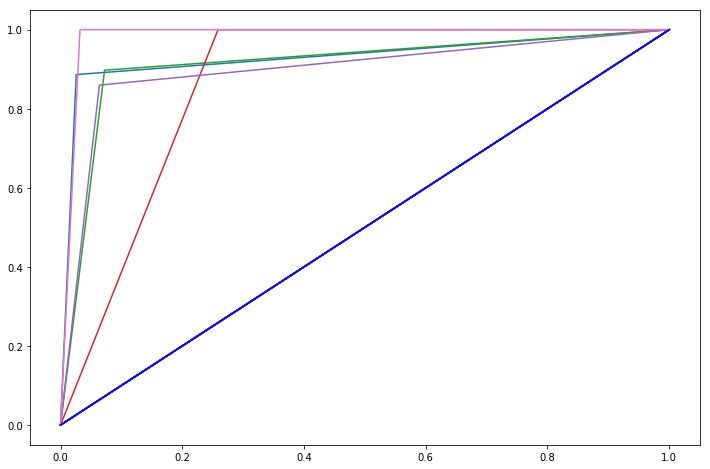

In [61]:
multiclass_roc_auc_score(valid_generator.classes, y_pred)

In [45]:
len(Y_pred)
print(len(valid_generator.classes))
len(y_pred)
valid_generator.samples

1354


1354

In [34]:
#len(y_pred)

In [35]:
def get_confusion_matrix(data_path, N):
    
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
            
    cm = confusion_matrix(targets, predictions)
    return cm

Generating confusion matrix 3827
Found 3827 images belonging to 8 classes.
[[433   0   6  18  23   0   0   0]
 [  3   0  29 377  18   0   0   0]
 [  2   0 482   2   4   0   0   0]
 [  1   0   0 465   0   0   0   0]
 [ 74   0   0  21 397   0   0   0]
 [ 21   0   5 387  77   0   0   0]
 [  0   0   0   2   0   0 488   0]
 [  8   0 155 157  33   4 135   0]]
Generating confusion matrix 3827
Found 1354 images belonging to 8 classes.
[[608   0   4  63  12   0   0   0]
 [  6   0  15 386  22   0   0   0]
 [  1   1 452   2  42   0   0   0]
 [  2   0   0 465   1   0   0   0]
 [ 66   0   0   0 426   0   0   0]
 [ 12   0   5 409  72   0   0   0]
 [  0   0   0   2   0   0 496   0]
 [  0   0 244  76  52   0 120   0]]


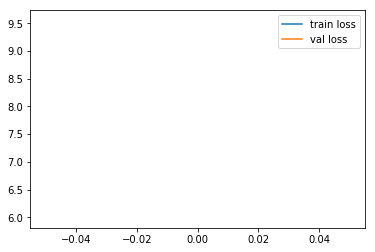

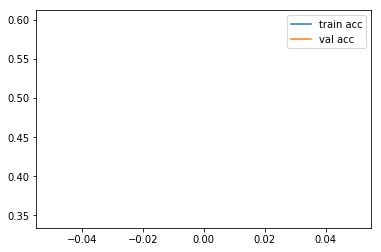

Confusion matrix, without normalization
[[433   0   6  18  23   0   0   0]
 [  3   0  29 377  18   0   0   0]
 [  2   0 482   2   4   0   0   0]
 [  1   0   0 465   0   0   0   0]
 [ 74   0   0  21 397   0   0   0]
 [ 21   0   5 387  77   0   0   0]
 [  0   0   0   2   0   0 488   0]
 [  8   0 155 157  33   4 135   0]]


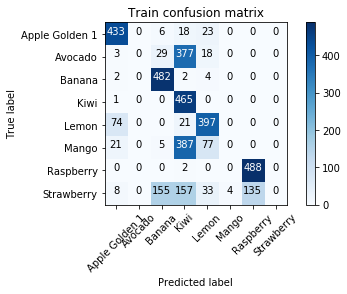

Confusion matrix, without normalization
[[608   0   4  63  12   0   0   0]
 [  6   0  15 386  22   0   0   0]
 [  1   1 452   2  42   0   0   0]
 [  2   0   0 465   1   0   0   0]
 [ 66   0   0   0 426   0   0   0]
 [ 12   0   5 409  72   0   0   0]
 [  0   0   0   2   0   0 496   0]
 [  0   0 244  76  52   0 120   0]]


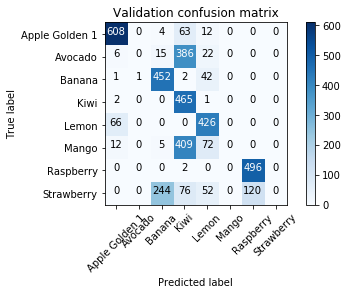

In [56]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')